In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../Pyfiles')
# Pull in the helper files.
from ImageRead import *
from QNN import *


/Users/bumkyu/miniforge3/envs/qiskit/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/bumkyu/miniforge3/envs/qiskit/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/bumkyu/miniforge3/envs/qiskit/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/bumkyu/miniforge3/envs/qiskit/lib/python3.8/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/bumkyu/miniforge3/envs/qiskit/bin/../lib/libpng16.16.dylib' (no such file), '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")


In [2]:
target_o = [0 for i in range(25)]+[1 for i in range(25)]

In [3]:
pathY=r'../dataset/Original/galaxy/'
pathN=r'../dataset/Original/No-galaxy/'
nameN=''
nameY=''
inputY=[imageResize(callImage(i+1,pathY,nameY),16) for i in range(25)]
inputN=[imageResize(callImage(i+1,pathN,nameN),16) for i in range(25)]
input_combine = inputY+inputN

In [4]:
np.random.seed(0)
idx=np.array([int(i) for i in range(50)]).flatten()

np.random.shuffle(idx)

dataInput = list(input_combine[i] for i in idx )
dataTarget = list( imageBinarize(input_combine[i]) for i in idx )

data_target_o=list( target_o[i] for i in idx )

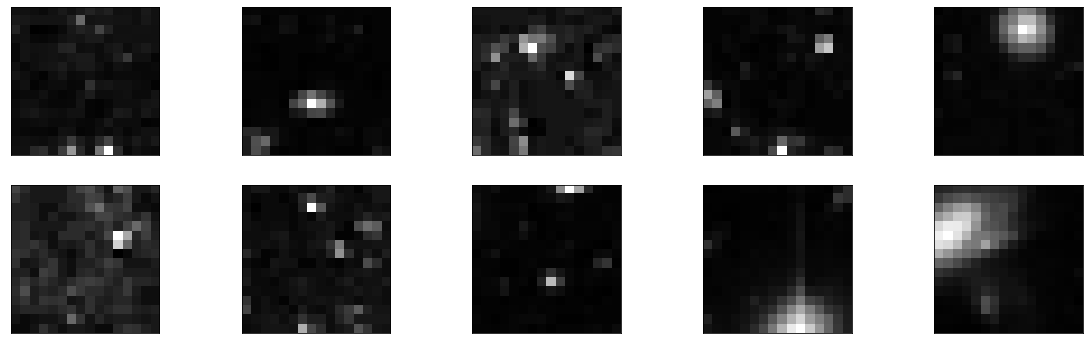

In [5]:
n_samples_show = 5
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(20, 6))

for i in range(n_samples_show):

    axes[0,i].imshow(dataInput[i], cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[1,i].imshow(dataInput[i+5], cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])    


In [6]:
Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

In [7]:
# n_samples_show = 5
# fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(15, 6))

# for i in range(5):
#     a = np.array_split(Xtest[i], 128)
#     a = [x.tolist() for x in a]
#     print(a)
#     axes[0,i].imshow(a, cmap='gray')
#     print(i)
#     axes[0,i].set_xticks([])
#     axes[0,i].set_yticks([])
#     axes[0,i].set_title("Label: {}".format(y01test[i]))
#     print(i)
#     axes[1,i].imshow(np.array(np.array_split(Xtest[i+5], 128)), cmap='gray')
#     axes[1,i].set_xticks([])
#     axes[1,i].set_yticks([])
#     axes[1,i].set_title("Label: {}".format(y01test[i+5]))    

In [8]:
from qiskit.circuit.parameter import Parameter
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import QuantumInstance
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

# Model for LBFGS
# Combining the circuit together with CircuitQNN
np.random.seed(3)


nqubits=6
num_inputs=256
qc = QuantumCircuit(nqubits)

# Encoding
param_x=[];
for i in range(num_inputs):
    param_x.append(Parameter('x'+str(i)))
for i in range(8):
    param_x.append(np.pi/2)


feature_map = encoding(qc,param_x,22)


# Optimzing circuit PQC
param_y=[];
for i in range(nqubits*2):
    param_y.append(Parameter('θ'+str(i)))

ansatz=circuit15(qc,param_y)

qc.append(feature_map, range(nqubits))
qc.append(ansatz, range(nqubits))

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=2, quantum_instance=qi)
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)


/Users/bumkyu/miniforge3/envs/qiskit/lib/python3.8/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/bumkyu/miniforge3/envs/qiskit/lib/python3.8/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [9]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.1)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(15)]
y01= [data_target_o[i] for i in range(15)]

In [10]:
from torch import Tensor
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.6666666666666666


In [11]:
# Test nidek accuracy

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

Accuracy: 0.6


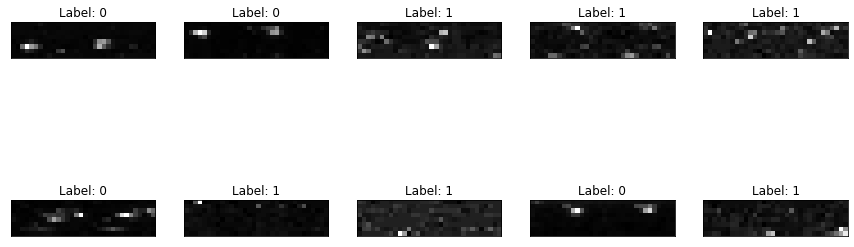

In [12]:
n_samples_show = 5
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(15, 6))

for i in range(5):
    axes[0,i].imshow(np.array(np.array_split(Xtest[i], 8)), cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[0,i].set_title("Label: {}".format(y01test[i]))
    axes[1,i].imshow(np.array(np.array_split(Xtest[i+5], 8)), cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])
    axes[1,i].set_title("Label: {}".format(y01test[i+5]))    

In [13]:
# from qiskit_machine_learning.neural_networks import CircuitQNN
# from qiskit_machine_learning.connectors import TorchConnector
# from qiskit.utils import QuantumInstance
# from torch.nn import Linear, CrossEntropyLoss, MSELoss
# from torch.optim import LBFGS, SGD,Adam 
# qi = QuantumInstance(Aer.get_backend('statevector_simulator'))
# from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
# from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
# from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

# # Model for LBFGS
# # Combining the circuit together with CircuitQNN
# np.random.seed(3)


# nqubits=6
# num_inputs=2**nqubits
# qc = QuantumCircuit(nqubits)

# param_x=[];
# for i in range(2**nqubits):
#     param_x.append(Parameter('x'+str(i)))
# for i in range(8):
#     param_x.append(np.pi/2)

# feature_map = encoding(qr,param_x,6)

# param_y=[];
# for i in range(nqubits*2):
#     param_y.append(Parameter('θ'+str(i)))

# ansatz=circuit15(qr,param_y)

# qc.append(feature_map, range(nqubits))
# qc.append(ansatz, range(nqubits))

# qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
#                   interpret=parity, output_shape=2, quantum_instance=qi)
# initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)


# Learning Rate 0.1

In [14]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.1)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(15)]
y01= [data_target_o[i] for i in range(15)]

In [15]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)
optimizer.step(closure)

10.560748100280762
10.508609771728516
9.778334617614746
9.754973411560059
9.688726425170898
9.59354019165039
9.461403846740723
9.331774711608887
9.241013526916504
9.171730041503906
9.111660957336426
9.059903144836426
9.016716957092285
8.980650901794434
8.950191497802734
8.92452621459961
8.90291976928711
8.884546279907227
8.868736267089844
8.855064392089844
8.843242645263672
8.833083152770996
8.824390411376953
8.817018508911133
8.810745239257812
8.805490493774414
8.801151275634766
8.797706604003906
8.79495620727539
8.792744636535645
8.790946960449219
8.789487838745117
8.788300514221191
8.787335395812988
8.78654956817627
8.785911560058594
8.785391807556152
8.784969329833984
8.784625053405762
8.784343719482422


tensor(8.8432, grad_fn=<AddBackward0>)

In [16]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.9333333333333333


In [17]:
# Test nidek accuracy

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

Accuracy: 0.9


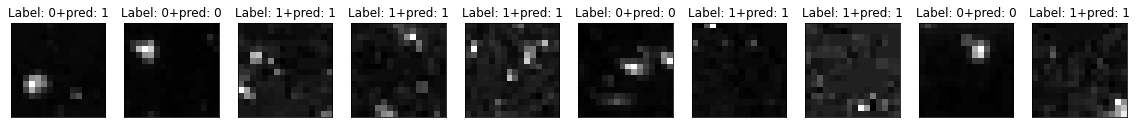

In [18]:
n_samples_show = 10
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 3))

for i in range(10):
    axes[i].imshow(np.array(np.array_split(Xtest[i], 16)), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("Label: {}".format(y01test[i])+"+pred: {}".format(y_predict[i]))

# Learning rate 0.01

In [19]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.01)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(15)]
y01= [data_target_o[i] for i in range(15)]

In [20]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)

10.560748100280762
10.555519104003906
10.322396278381348
10.263618469238281
10.231043815612793
10.19247817993164
10.145801544189453
10.094972610473633
10.045539855957031
10.000255584716797
9.959122657775879
9.921398162841797
9.886467933654785
9.853927612304688
9.823494911193848
9.79495906829834
9.768142700195312
9.742895126342773
9.719085693359375
9.696598052978516


tensor(10.5607, grad_fn=<AddBackward0>)

In [21]:
optimizer.step(closure)

9.675323486328125
9.655163764953613
9.636028289794922
9.617837905883789
9.600512504577637
9.583980560302734
9.568174362182617
9.553031921386719
9.538493156433105
9.524505615234375
9.511015892028809
9.49797534942627
9.48534107208252
9.473069190979004
9.461128234863281
9.449478149414062
9.438090324401855
9.4269380569458
9.416000366210938
9.405258178710938


tensor(9.6753, grad_fn=<AddBackward0>)

In [22]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.9333333333333333


In [23]:
# Test nidek accuracy

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

Accuracy: 0.9


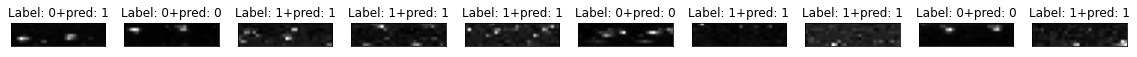

In [24]:
n_samples_show = 10
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 3))

for i in range(10):
    axes[i].imshow(np.array(np.array_split(Xtest[i], 8)), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("Label: {}".format(y01test[i])+"+pred: {}".format(y_predict[i]))

In [26]:
target_o = [0 for i in range(25)]+[1 for i in range(25)]

pathY=r'../dataset/Original/galaxy1/'
pathN=r'../dataset/Original/No-galaxy1/'
nameN=''
nameY=''
inputY=[imageResize(callImage(i+1,pathY,nameY),16) for i in range(25)]
inputN=[imageResize(callImage(i+1,pathN,nameN),16) for i in range(25)]
input_combine = inputY+inputN

np.random.seed(0)
idx=np.array([int(i) for i in range(50)]).flatten()

np.random.shuffle(idx)

dataInput = list(input_combine[i] for i in idx )
dataTarget = list( imageBinarize(input_combine[i]) for i in idx )

data_target_o=list( target_o[i] for i in idx )

Xtest= [normlaizeData(dataInput[i].flatten()) for i in range(25)]
y01test= [data_target_o[i] for i in range(25)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

Accuracy: 0.68
